In [6]:
#make the input directory to store all the train and test data
!mkdir /home/MC-Shenzhen/test
!mkdir /home/MC-Shenzhen/train
!mkdir /home/MC-Shenzhen/train/image
!mkdir /home/MC-Shenzhen/train/mask
!mkdir /home/MC-Shenzhen/train/dilate

In [1]:
#import required files
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.optimizers import adam_v2
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

from glob import glob
from tqdm import tqdm

In [2]:
#Shenzhen path to CXR and Mask Image
INPUT_DIR = "/home/MC-Shenzhen"
SHENZHEN_INPUT_DIR = os.path.join(INPUT_DIR,"ChinaSet_AllFiles" ,"ChinaSet_AllFiles")
SHENZHEN_IMAGE_DIR = os.path.join(SHENZHEN_INPUT_DIR, "CXR_png")
SHENZHEN_MASK_DIR = os.path.join(SHENZHEN_INPUT_DIR, "CXR_mask")

In [3]:
#Montgomery Image
MONTGOMERY_INPUT_DIR = os.path.join(INPUT_DIR,"Montgomery","MontgomerySet")
MONTGOMERY_IMAGE_DIR = os.path.join(MONTGOMERY_INPUT_DIR, "CXR_png")
MONTGOMERY_LEFT_MASK_DIR = os.path.join(MONTGOMERY_INPUT_DIR, "ManualMask", "leftMask")
MONTGOMERY_RIGHT_MASK_DIR = os.path.join(MONTGOMERY_INPUT_DIR,"ManualMask", "rightMask")

In [4]:
DILATE_KERNEL = np.ones((15, 15), np.uint8)
BATCH_SIZE=16
EPOCHS=500
GRID_SIZE = (8,8)
CLIP_LIMIT = 40
IMAGE_SHAPE = (256,256)

In [5]:
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))

In [6]:
#Test train split

#shuffle the list of files
import random
montgomery_left_mask_dir = glob(os.path.join(MONTGOMERY_LEFT_MASK_DIR, '*.png'))
random.shuffle(montgomery_left_mask_dir)

total = len(montgomery_left_mask_dir)
val_cnt = int(0.3*total)
print('total: ',total,'training: ',(total - val_cnt),'validation: ',val_cnt)

#test train split
montgomery_test = montgomery_left_mask_dir[0:val_cnt]
montgomery_train= montgomery_left_mask_dir[val_cnt:]

total:  138 training:  97 validation:  41


#### Montgomery County Data Preparation

- Combine left and right lung segmentation masks of Montgomery chest x-rays
- Resize images to 256x256 pixels
- Dilate masks to gain more information on the edge of lungs
- Split images into training and test datasets
- Write images to /segmentation directory

In [7]:
#apply CLAHE enhancement filter
def apply_clahe(image,clip_limit=15,grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit= clip_limit, tileGridSize= grid_size)
    equalized = clahe.apply(image)
    return equalized

In [8]:
TRAIN_DIR = os.path.join(INPUT_DIR,"train")
TEST_DIR = os.path.join(INPUT_DIR,"test")

TRAIN_IMAGE_DIR = os.path.join(TRAIN_DIR,"image")
TEST_IMAGE_DIR = os.path.join(TEST_DIR,"test","image")

MASK_DIR = os.path.join(TRAIN_DIR,"mask")
DILATE_DIR = os.path.join(TRAIN_DIR,"dilate")

In [17]:
for left_image_file in tqdm(montgomery_left_mask_dir):
    base_file = os.path.basename(left_image_file)
    image_file = os.path.join(MONTGOMERY_IMAGE_DIR, base_file)
    right_image_file = os.path.join(MONTGOMERY_RIGHT_MASK_DIR, base_file)

    image = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
    left_mask = cv2.imread(left_image_file, cv2.IMREAD_GRAYSCALE)
    right_mask = cv2.imread(right_image_file, cv2.IMREAD_GRAYSCALE)
    
    #resize original image and apply clahe
    image = cv2.resize(image, IMAGE_SHAPE)
    image = apply_clahe(image,CLIP_LIMIT,GRID_SIZE)
    
    left_mask = cv2.resize(left_mask, IMAGE_SHAPE)
    right_mask = cv2.resize(right_mask, IMAGE_SHAPE)
    
    mask = np.maximum(left_mask, right_mask)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (left_image_file in montgomery_train):
        cv2.imwrite(os.path.join(TRAIN_IMAGE_DIR, base_file),image)
        cv2.imwrite(os.path.join(MASK_DIR, base_file),mask)
        cv2.imwrite(os.path.join(DILATE_DIR, base_file),mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(TEST_DIR, base_file),image)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 138/138 [00:32<00:00,  4.27it/s]


Define functions for segmentation overlay

In [9]:
def add_colored_dilate(image, mask_image, dilate_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    dilate_image_gray = cv2.cvtColor(dilate_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    dilate = cv2.bitwise_and(dilate_image, dilate_image, mask=dilate_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])
    dilate_coord = np.where(dilate!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]
    dilate[dilate_coord[0],dilate_coord[1],:] = [0,0,255]

    ret = cv2.addWeighted(image, 0.7, dilate, 0.3, 0)
    ret = cv2.addWeighted(ret, 0.7, mask, 0.3, 0)

    return ret

def add_colored_mask(image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(image, 0.7, mask, 0.3, 0)

    return ret

def diff_mask(ref_image, mask_image):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    
    mask_coord = np.where(mask!=[0,0,0])

    mask[mask_coord[0],mask_coord[1],:]=[255,0,0]

    ret = cv2.addWeighted(ref_image, 0.7, mask, 0.3, 0)
    return ret

Show some Montgomery chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

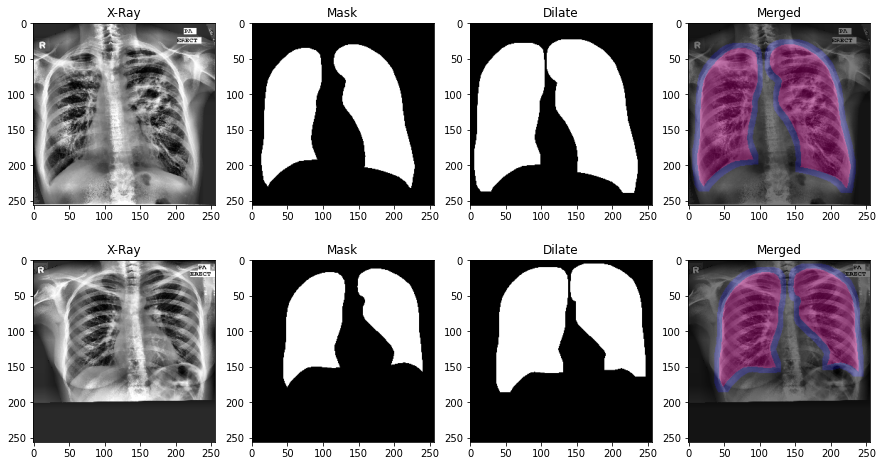

In [19]:
base_file = os.path.basename(montgomery_train[0])

image_file = os.path.join(TRAIN_IMAGE_DIR, base_file)
mask_image_file = os.path.join(MASK_DIR, base_file)
dilate_image_file = os.path.join(DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(montgomery_test[0])
filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(TEST_DIR, base_file)
mask_image_file = os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)
plt.show()

#### Shenzhen dataset preparation
- Resize Shenzhen Hospital chest x-ray images to 256X256 pixels
- Dilate masks to gain more information on the edge of lungs
- Split images into training and test datasets
- Write images to /segmentation directory

In [10]:
#shuffle shenzhen file list
shenzhen_mask_dir = glob(os.path.join(SHENZHEN_MASK_DIR, '*.png'))
random.shuffle(shenzhen_mask_dir)
print('shenzhen length: ',len(shenzhen_mask_dir))

total = len(shenzhen_mask_dir)
val_cnt = int(0.3*total)
print('total: ',total,'training: ',(total - val_cnt),'validation: ',val_cnt)
#get shenzhen test data train data
shenzhen_test = shenzhen_mask_dir[0:val_cnt]
shenzhen_train= shenzhen_mask_dir[val_cnt:]

shenzhen length:  566
total:  566 training:  397 validation:  169


In [36]:
SHENZHEN_IMAGE_DIR

'/home/MC-Shenzhen/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png'

In [37]:
for mask_file in tqdm(shenzhen_mask_dir):
    base_file = os.path.basename(mask_file).replace("_mask", "")
    image_file = os.path.join(SHENZHEN_IMAGE_DIR, base_file)

    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
        
    image = cv2.resize(image, IMAGE_SHAPE)
    image = apply_clahe(image,CLIP_LIMIT,GRID_SIZE)
    
    mask = cv2.resize(mask, IMAGE_SHAPE)
    mask_dilate = cv2.dilate(mask, DILATE_KERNEL, iterations=1)
    
    if (mask_file in shenzhen_train):
        cv2.imwrite(os.path.join(TRAIN_IMAGE_DIR, base_file), image)
        cv2.imwrite(os.path.join(MASK_DIR, base_file), mask)
        cv2.imwrite(os.path.join(DILATE_DIR, base_file), mask_dilate)
    else:
        filename, fileext = os.path.splitext(base_file)
        cv2.imwrite(os.path.join(TEST_DIR, base_file), image)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext)), mask)
        cv2.imwrite(os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext)), mask_dilate)

100%|██████████| 566/566 [01:07<00:00,  8.34it/s]


Show some Shenzhen Hospital chest x-rays and its lung segmentation masks from training and test dataset to verify the procedure above. In merged image it is possible to see the difference between the dilated mask in blue and the original mask in red.

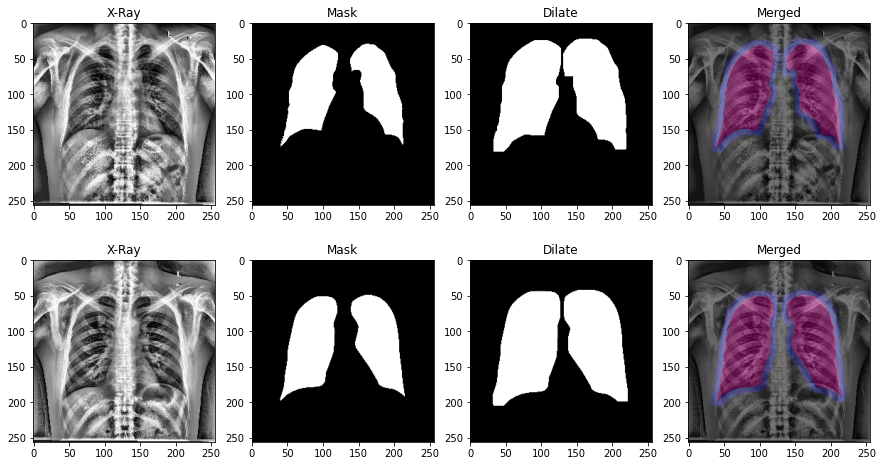

In [38]:
base_file = os.path.basename(shenzhen_train[0].replace("_mask", ""))

image_file = os.path.join(TRAIN_IMAGE_DIR, base_file)
mask_image_file = os.path.join(MASK_DIR, base_file)
dilate_image_file = os.path.join(DILATE_DIR, base_file)

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)
                          
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

axs[0, 0].set_title("X-Ray")
axs[0, 0].imshow(image)

axs[0, 1].set_title("Mask")
axs[0, 1].imshow(mask_image)

axs[0, 2].set_title("Dilate")
axs[0, 2].imshow(dilate_image)

axs[0, 3].set_title("Merged")
axs[0, 3].imshow(merged_image)

base_file = os.path.basename(shenzhen_test[0].replace("_mask", ""))
image_file = os.path.join(TEST_DIR, base_file)
filename, fileext = os.path.splitext(base_file)
mask_image_file = os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext))

filename, fileext = os.path.splitext(base_file)
image_file = os.path.join(TEST_DIR, base_file)
mask_image_file = os.path.join(TEST_DIR, "%s_mask%s" % (filename, fileext))
dilate_image_file = os.path.join(TEST_DIR, "%s_dilate%s" % (filename, fileext))

image = cv2.imread(image_file)
mask_image = cv2.imread(mask_image_file)
dilate_image = cv2.imread(dilate_image_file)
merged_image = add_colored_dilate(image, mask_image, dilate_image)

axs[1, 0].set_title("X-Ray")
axs[1, 0].imshow(image)

axs[1, 1].set_title("Mask")
axs[1, 1].imshow(mask_image)

axs[1, 2].set_title("Dilate")
axs[1, 2].imshow(dilate_image)

axs[1, 3].set_title("Merged")
axs[1, 3].imshow(merged_image)
plt.show()

Print the count of images and segmentation lung masks available to test and train the model

In [11]:
train_files = glob(os.path.join(TRAIN_IMAGE_DIR, "*.png"))
test_files = glob(os.path.join(TEST_DIR, "*.png"))
mask_files = glob(os.path.join(MASK_DIR, "*.png"))
dilate_files = glob(os.path.join(DILATE_DIR, "*.png"))

(len(train_files), \
 len(test_files), \
 len(mask_files), \
 len(dilate_files))

(494, 840, 494, 494)

` Montgomery County: 97 train, 41 test
 Shenzhen: 397 train, 169 test
 Total train: 494
 Total Test: 210 X3 types image`

### Segmentation Training

#### Data Augmentation

In [12]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
        image_color_mode="grayscale",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=IMAGE_SHAPE,
        seed=42):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

#### UNET Architecture

In [13]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    # CONTRACTING PATH
    # Downsampling 1
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Downsampling 2
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Downsampling 3
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Downsampling 4
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # EXPANDING PATH
    # Upsampling & Concatenate 1
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    # Upsampling & Concatenate 2
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Upsampling & Concatenate 3
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    # Upsampling & Concatenate 4
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Helper function to load test CXR images

In [14]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def test_load_image(test_file, target_size=(256,256)):
    img = cv2.imread(test_file, cv2.IMREAD_GRAYSCALE)
    img = img / 255
    img = cv2.resize(img, target_size)
    img = np.reshape(img, img.shape + (1,))
    img = np.reshape(img,(1,) + img.shape)
    return img

def test_generator(test_files, target_size=(256,256)):
    for test_file in test_files:
        yield test_load_image(test_file, target_size)
        
def save_result(save_path, npyfile, test_files):
    for i, item in enumerate(npyfile):
        result_file = test_files[i]
        img = (item[:, :, 0] * 255.).astype(np.uint8)

        filename, fileext = os.path.splitext(os.path.basename(result_file))

        result_file = os.path.join(save_path, "%s_predict%s" % (filename, fileext))

        cv2.imwrite(result_file, img)

`Select Test and Validation files`

In [15]:
def add_suffix(base_file, suffix):
    filename, fileext = os.path.splitext(base_file)
    return "%s_%s%s" % (filename, suffix, fileext)

test_files = [test_file for test_file in glob(os.path.join(TEST_DIR, "*.png")) \
              if ("_mask" not in test_file \
                  and "_dilate" not in test_file \
                  and "_predict" not in test_file)]

validation_data = (test_load_image(test_files[0], target_size=(256, 256)),
                    test_load_image(add_suffix(test_files[0], "dilate"), target_size=(256, 256)))

len(test_files), len(validation_data)

(210, 2)

In [16]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


earlystop = EarlyStopping(monitor='loss',
                          min_delta=.0001,
                          patience=30,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='loss',
                             factor=np.sqrt(.1),
                             patience=20,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

#### Model Compilation

In [19]:
#model summart
EPOCHS = 500
from keras.optimizers import adam_v2
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = train_generator(BATCH_SIZE,
                            TRAIN_DIR,
                            'image',
                            'dilate', 
                            train_generator_args,
                            target_size=IMAGE_SHAPE,
                            save_to_dir=None)
model = unet(input_size=(256,256,1))
learning_rate = adam_v2.Adam(learning_rate=1e-4)
model.compile(optimizer=learning_rate, loss=dice_coef_loss, \
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_19[0][0]']              
                                )                                                           

#### Model Fit Generator

In [20]:
SAVED_MODEL_NAME = 'unet-base-val-loss-lre3.hdf5'
model_checkpoint = ModelCheckpoint(SAVED_MODEL_NAME, 
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True)

history = model.fit(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=EPOCHS, 
                              callbacks=[model_checkpoint,earlystop,reducelr],
                              validation_data = validation_data)

Found 494 images belonging to 1 classes.
Found 494 images belonging to 1 classes.
Epoch 1/500
31/30 [==============================] - ETA: 0s - loss: -0.4439 - dice_coef: 0.4442 - binary_accuracy: 0.3767
Epoch 00001: val_loss improved from inf to -0.55825, saving model to unet-base-val-loss-lre3.hdf5
30/30 [==============================] - 7s 182ms/step - loss: -0.4439 - dice_coef: 0.4442 - binary_accuracy: 0.3767 - val_loss: -0.5582 - val_dice_coef: 0.5582 - val_binary_accuracy: 0.3876 - lr: 1.0000e-04
Epoch 2/500
31/30 [==============================] - ETA: 0s - loss: -0.5394 - dice_coef: 0.5395 - binary_accuracy: 0.3685
Epoch 00002: val_loss improved from -0.55825 to -0.58841, saving model to unet-base-val-loss-lre3.hdf5
30/30 [==============================] - 5s 175ms/step - loss: -0.5394 - dice_coef: 0.5395 - binary_accuracy: 0.3685 - val_loss: -0.5884 - val_dice_coef: 0.5884 - val_binary_accuracy: 0.3876 - lr: 1.0000e-04
Epoch 3/500
31/30 [==============================] - ET

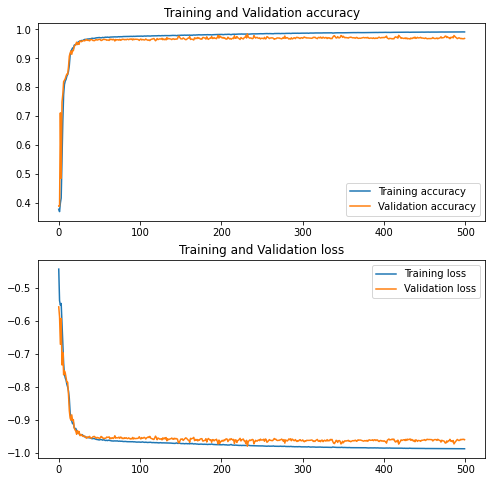

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['binary_accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_binary_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.show()

In [22]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,dice_coef,binary_accuracy,val_loss,val_dice_coef,val_binary_accuracy,lr
epoch,,,,,,,
232,-0.978433,0.978430,0.984223,-0.980363,0.980363,0.984512,0.0001
418,-0.986251,0.986247,0.989928,-0.974136,0.974136,0.979477,0.0001
196,-0.975909,0.975888,0.982400,-0.973879,0.973879,0.979446,0.0001
347,-0.984221,0.984223,0.988431,-0.973578,0.973578,0.978851,0.0001
486,-0.988231,0.988233,0.991363,-0.973499,0.973499,0.979019,0.0001
...,...,...,...,...,...,...,...
5,-0.670348,0.670568,0.681298,-0.696540,0.696540,0.775375,0.0001
2,-0.553192,0.553301,0.398033,-0.671801,0.671801,0.710754,0.0001
3,-0.548027,0.548129,0.415603,-0.593266,0.593266,0.483963,0.0001


In [23]:
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=.0001,
                          patience=30,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=20,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

FINETUNE_EPOCH = 700
learning_rate = adam_v2.Adam(learning_rate=1e-5)
model.compile(optimizer=learning_rate, loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])
history_finetune = model.fit(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE, 
                              epochs=FINETUNE_EPOCH, 
                              callbacks=[model_checkpoint,earlystop,reducelr],
                              initial_epoch = history.epoch[-1],
                              validation_data = validation_data)

Epoch 500/700
31/30 [==============================] - ETA: 0s - loss: -0.9890 - dice_coef: 0.9890 - binary_accuracy: 0.9919
Epoch 00500: val_loss did not improve from -0.98036
30/30 [==============================] - 7s 183ms/step - loss: -0.9890 - dice_coef: 0.9890 - binary_accuracy: 0.9919 - val_loss: -0.9605 - val_dice_coef: 0.9605 - val_binary_accuracy: 0.9687 - lr: 1.0000e-05
Epoch 501/700
31/30 [==============================] - ETA: 0s - loss: -0.9893 - dice_coef: 0.9893 - binary_accuracy: 0.9921
Epoch 00501: val_loss did not improve from -0.98036
30/30 [==============================] - 5s 171ms/step - loss: -0.9893 - dice_coef: 0.9893 - binary_accuracy: 0.9921 - val_loss: -0.9618 - val_dice_coef: 0.9618 - val_binary_accuracy: 0.9695 - lr: 1.0000e-05
Epoch 502/700
31/30 [==============================] - ETA: 0s - loss: -0.9893 - dice_coef: 0.9893 - binary_accuracy: 0.9922
Epoch 00502: val_loss did not improve from -0.98036
30/30 [==============================] - 5s 176ms/ste

In [24]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,dice_coef,binary_accuracy,val_loss,val_dice_coef,val_binary_accuracy,lr
epoch,,,,,,,
15,-0.989872,0.989870,0.992595,-0.963263,0.963263,0.970749,0.000010
22,-0.989999,0.990001,0.992687,-0.963187,0.963187,0.970718,0.000010
28,-0.990137,0.990136,0.992744,-0.963120,0.963120,0.970657,0.000010
27,-0.990230,0.990231,0.992818,-0.962834,0.962834,0.970413,0.000010
19,-0.989996,0.989995,0.992658,-0.962661,0.962661,0.970352,0.000010
20,-0.990002,0.990005,0.992675,-0.962621,0.962621,0.970245,0.000010
14,-0.989889,0.989889,0.992576,-0.962557,0.962557,0.970123,0.000010
26,-0.990121,0.990120,0.992742,-0.962481,0.962481,0.970184,0.000010
30,-0.990117,0.990116,0.992800,-0.962432,0.962432,0.970078,0.000010


In [25]:
SEGMENTATION_TEST_DIR = TEST_DIR
test_gen = test_generator(test_files, target_size=(256,256))
results = model.predict_generator(test_gen, len(test_files), verbose=1)
save_result(SEGMENTATION_TEST_DIR, results, test_files)

/tmp/ipykernel_587/2078819674.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = model.predict_generator(test_gen, len(test_files), verbose=1)


210/210 [==============================] - 1s 5ms/step


### Results

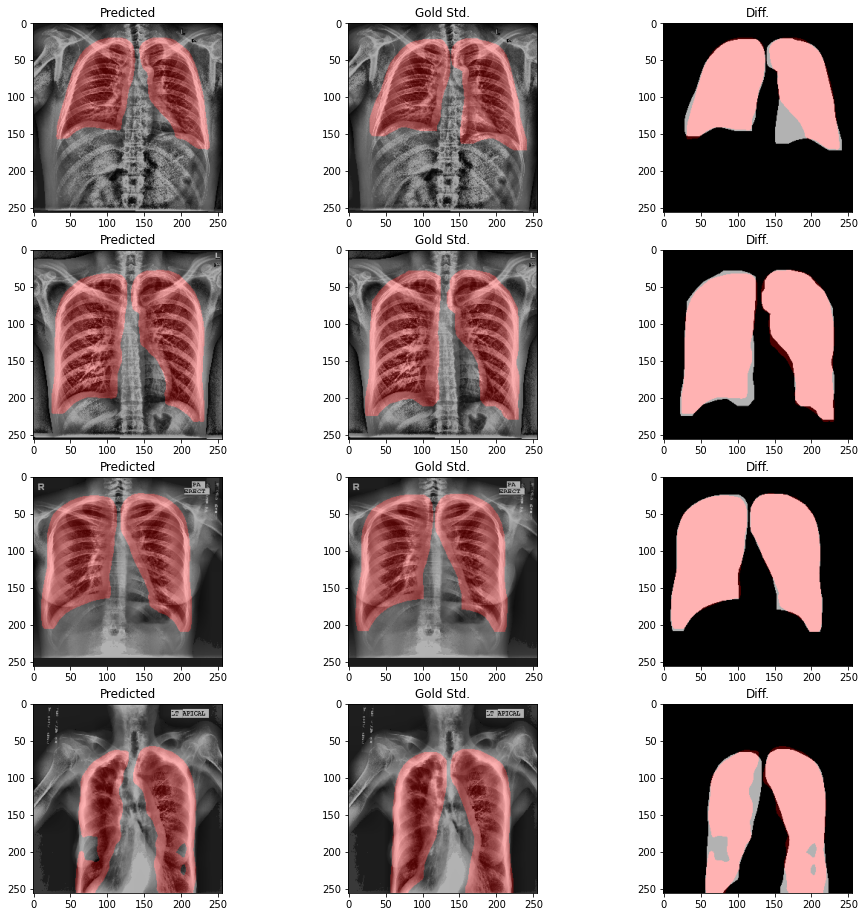

In [26]:
fig, axs = plt.subplots(4, 3, figsize=(16, 16))

image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'CHNCXR_0013_0.png'))
predict_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'CHNCXR_0013_0_predict.png'))
mask_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'CHNCXR_0013_0_dilate.png'))

axs[0, 0].set_title("Predicted")
axs[0, 0].imshow(add_colored_mask(image, predict_image))
axs[0, 1].set_title("Gold Std.")
axs[0, 1].imshow(add_colored_mask(image, mask_image))
axs[0, 2].set_title("Diff.")
axs[0, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'CHNCXR_0426_1.png'))
predict_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'CHNCXR_0426_1_predict.png'))
mask_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'CHNCXR_0426_1_dilate.png'))

axs[1, 0].set_title("Predicted")
axs[1, 0].imshow(add_colored_mask(image, predict_image))
axs[1, 1].set_title("Gold Std.")
axs[1, 1].imshow(add_colored_mask(image, mask_image))
axs[1, 2].set_title("Diff.")
axs[1, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'MCUCXR_0046_0.png'))
predict_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'MCUCXR_0046_0_predict.png'))
mask_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'MCUCXR_0046_0_dilate.png'))

axs[2, 0].set_title("Predicted")
axs[2, 0].imshow(add_colored_mask(image, predict_image))
axs[2, 1].set_title("Gold Std.")
axs[2, 1].imshow(add_colored_mask(image, mask_image))
axs[2, 2].set_title("Diff.")
axs[2, 2].imshow(diff_mask(mask_image, predict_image))

image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'MCUCXR_0251_1.png'))
predict_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'MCUCXR_0251_1_predict.png'))
mask_image = cv2.imread(os.path.join(SEGMENTATION_TEST_DIR,'MCUCXR_0251_1_dilate.png'))

axs[3, 0].set_title("Predicted")
axs[3, 0].imshow(add_colored_mask(image, predict_image))
axs[3, 1].set_title("Gold Std.")
axs[3, 1].imshow(add_colored_mask(image, mask_image))
axs[3, 2].set_title("Diff.")
axs[3, 2].imshow(diff_mask(mask_image, predict_image))
plt.show()